# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [2]:
import numpy as np
import skimage
import skimage.io
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
import random
from skimage.transform import ProjectiveTransform, warp

# Helper functions

In [3]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [27]:
def get_best_matches(img1, img2, num_matches):
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    dist1 = []
    dist2 = []
    dist3 = []
    for i in range(dist.shape[0]):
        dist1.append(min(dist[i,:]))
    for j in range(dist.shape[1]):
        dist2.append(min(dist[:,j]))
    for i in range(len(dist1)):
        for j in range(len(dist2)):
            if dist1[i] == dist2[j]:
                dist3.append([dist1[i],i,j])
    dist3 = sorted(dist3)[:num_matches]
    data = []
    for item in dist3:
        x1, y1 = kp1[item[1]].pt
        x2, y2 = kp2[item[2]].pt
        data.append([x1, y1, x2, y2])
    data = np.array(data, dtype = 'int')
    return data

def residual(match, h):

    p1 = np.transpose(np.matrix([match[0], match[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([match[2], match[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)

def ransac(data, threshold = 0.9, iteration = 1000):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    max_linear = []
    best_model = None
    best_residual = None
    for i in range(iteration):
        match1 = data[random.randrange(0, len(data))]
        match2 = data[random.randrange(0, len(data))]
        fourMatches = np.vstack((match1, match2))
        match3 = data[random.randrange(0, len(data))]
        fourMatches = np.vstack((fourMatches, match3))
        match4 = data[random.randrange(0, len(data))]
        fourMatches = np.vstack((fourMatches, match4))

        h = compute_homography(fourMatches)
        inliers = []
        
        all_residual = 0
        for i in range(len(data)):
            r = residual(data[i], h)
            if r < 5:
                inliers.append(data[i])
            all_residual += r

        if len(inliers) > len(max_linear):
            max_linear = inliers
            best_model = h
            best_residual = all_residual / len(data)
#         print("data size: ", len(data), " NumInliers: ", len(inliers), "Max inliers: ", len(max_linear))
        if len(max_linear) > (len(data)*threshold):
            break
    return best_model, max_linear, best_residual

def compute_homography(fourMatches):
    """
    write your code to compute homography according to the matches
    """
    # <YOUR CODE>
    A = []
    for match in fourMatches:
        p1 = np.matrix([match[0], match[1], 1])
        p2 = np.matrix([match[2], match[3], 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        A.append(a1)
        A.append(a2)

    A = np.matrix(A)

    u, s, v = np.linalg.svd(A)
    h = np.reshape(v[8], (3, 3))
    h = (1/h.item(8)) * h
    return h

def warp_images(H, img1, img2):
    """
    write your code to stitch images together according to the homography
    """
    # <YOUR CODE>
    height = img1.shape[0]
    width = img1.shape[1] + img2.shape[1]
    depth = img1.shape[2]
    trans = ProjectiveTransform(H)
    img2_trans = warp(img2, trans, output_shape=(height,width,depth))
    img2_trans = img2_trans * 255.
    img2_trans = img2_trans.astype('int')
    img1_trans = np.zeros((height, width, depth), dtype = 'int')
    img1_trans[:,:img1.shape[1]] = img1
    warped_img = np.zeros((height, width, depth), dtype = 'int')
    for i in range(warped_img.shape[0]):
        for j in range(warped_img.shape[1]):
#             if (img2_trans[i][j] != 0).all() and (img1_trans[i][j] != 0).all():
#                 warped_img[i][j] = (img2_trans[i][j] + img1_trans[i][j]) / 2
            if (img2_trans[i][j] != 0).all():
                warped_img[i][j] = img2_trans[i][j]
            else:
                warped_img[i][j] = img1_trans[i][j]
#     plt.figure()
#     plt.imshow(warped_img)
#     plt.show()
    return warped_img
# data = get_best_matches(img1, img2, 300)
# ransac(data)
# warp_images(best_model, img1, img2)

array([[[168, 184, 217],
        [170, 186, 219],
        [170, 186, 219],
        ...,
        [ 98, 138, 189],
        [ 98, 138, 190],
        [ 99, 139, 191]],

       [[166, 182, 215],
        [168, 184, 217],
        [167, 183, 216],
        ...,
        [ 98, 138, 190],
        [ 98, 138, 190],
        [ 98, 139, 191]],

       [[168, 184, 217],
        [169, 185, 218],
        [168, 184, 217],
        ...,
        [ 98, 138, 190],
        [ 98, 139, 191],
        [ 98, 139, 191]],

       ...,

       [[ 15,  20,  24],
        [ 16,  19,  24],
        [ 13,  16,  21],
        ...,
        [251, 238, 216],
        [251, 238, 216],
        [252, 238, 217]],

       [[ 13,  18,  22],
        [ 15,  18,  23],
        [ 14,  17,  22],
        ...,
        [250, 238, 214],
        [250, 238, 214],
        [250, 238, 214]],

       [[ 12,  17,  21],
        [ 15,  18,  23],
        [ 15,  18,  23],
        ...,
        [250, 238, 214],
        [250, 238, 214],
        [250, 238, 214]]

# Main functions

#### Load images

In [5]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

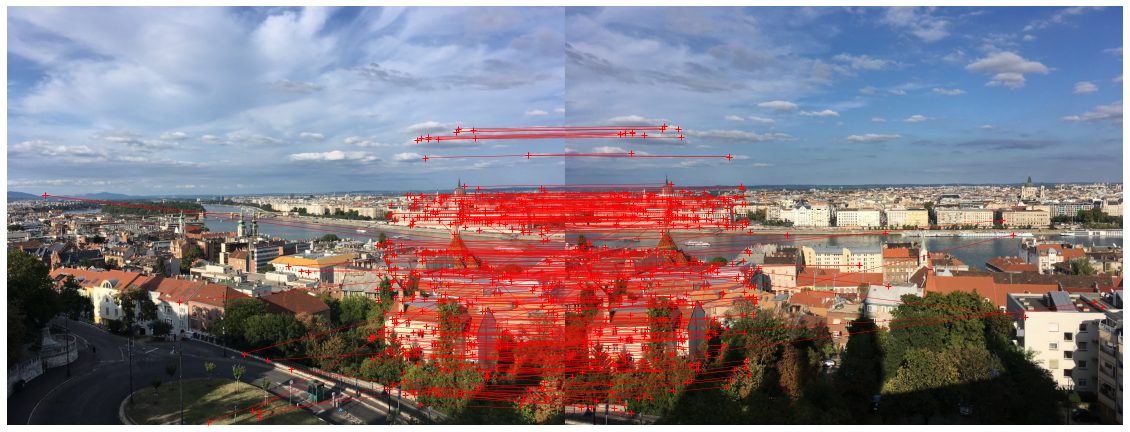

In [6]:
data = get_best_matches(img1, img2, 400)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

Best model: [[ 2.65165590e+00  3.45666297e-02 -1.74208334e+03]
 [ 5.72851621e-01  2.32297434e+00 -4.67083753e+02]
 [ 1.68180048e-03 -4.54430162e-05  1.00000000e+00]]
Average residual: 39.87895234258101
Inliers: 374
0.10662821481973532


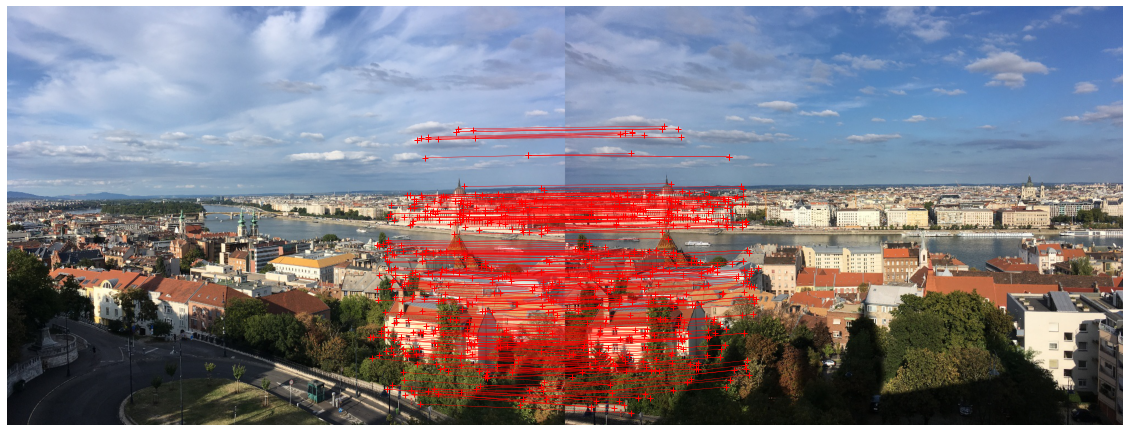

In [9]:
# display the inlier matching, report the average residual
# <YOUR CODE>
best_model, max_inliers, best_model_errors = ransac(data)
max_inliers = np.array(max_inliers)
print("Best model:", best_model)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", len(max_inliers))
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, max_inliers)
fig.savefig('ransac_match.pdf', bbox_inches='tight')
print(best_model_errors / len(max_inliers))

#### Part (5) warp images to stitch them together

In [10]:
# display and report the stitching results
# <YOUR CODE>
im = warp_images(best_model, img1, img2)
cv2.imwrite('stitched_images.jpg', im[:,:,::-1], 
            [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True